<a href="https://colab.research.google.com/github/AkiraNom/Automated_analysis/blob/main/Analysis_automation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import glob
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import time

# pip3 install chardet
import chardet

# libraries for creating a pdf file
import fpdf
from fpdf import FPDF
import dataframe_image as dfi

from tqdm.notebook import tqdm

In [3]:
file_paths = glob.glob('./drive/MyDrive/ECG_files/ExpID*.csv')

In [102]:
# define a folder path
def get_file_paths(folder_path):
  return glob.glob(f'{folder_path}ExpID*.csv')

# check encoding type in csv
'''
CSV files exported by LabChart, ADInstrument are 'ISO-8859-1'.
In case you do not change an encoding option, 'UnicodeDecodeError' will be raised.
To avoid a error, check an encoding option before reading a file with pandas
'''
def get_csv_encoding(file_path):
  with open(file_path, "rb") as file:
    # Read the csv file in binary and check the encoding
    result = chardet.detect(file.read())
    encoding = result["encoding"]
  return encoding

# Read multiple CSV files and create a DataFrame
def read_csv_files(file_paths):
    dfs = []

    print('reading csv files...')
    for file_path in tqdm(file_paths):
      try:
        # specify rows and columns to import
        import_rows = [0,1]
        import_cols = list(range(9))

        # check csv encoding type
        encoding = get_csv_encoding(file_path)

        df = pd.read_csv(file_path,
                         index_col = 0,
                         usecols=import_cols,
                         skiprows = lambda x: x not in import_rows,
                         encoding=encoding
                        )
        # add experimental ID
        myid = int(file_path[-8:-4])
        idx = 0
        df.insert(loc=idx,column = 'Exp_Id', value = myid)
        dfs.append(df)

      except UnicodeDecodeError:
        myid = int(file_path[-8:-4])
        print (f'Encording type error for id {myid}')

    return pd.concat(dfs, axis=0, ignore_index=True)

# convert obj to datetime
def convert_datetime(data):
  """
  The timedate column contains the recording date and time.
  This function extracts dates and converts them to DateTime in pandas
  """
  dates = pd.to_datetime(data.TimeDate.apply(lambda x : x.split(' ')[0]), format='%m/%d/%Y')
  data.TimeDate = dates.dt.strftime('%Y/%m/%d')

  return data

# Read meta data
def read_meta_file(folder_path):
  file_path = glob.glob(f'{folder_path}meta*.csv')[0]
  try:
    return pd.read_csv(file_path)

  except FileNotFoundError:
    print('Meta info is not present')

# Run normality test on each column
def run_normality_tests(data):
    normality_results = {}
    for column in data.columns:
        _, p_value = stats.normaltest(data[column])
        if p_value < 0.05:
            normality_results[column] = False  # Not normally distributed
        else:
            normality_results[column] = True  # Normally distributed
    return normality_results

# Run appropriate statistical tests based on normality
def run_statistical_tests(data, group_column):
    groups = data[group_column].unique()
    p_values = {}

    if len(groups) ==2:
      group1 = data[data[group_column] == groups[0]]
      group2 = data[data[group_column] == groups[1]]

      results = {}
      for column in data.columns:
        if column == group_column:
          continue  # Skip the grouping column itself

        if normality_results[column]:
            _, p_value = stats.ttest_ind(group1[column], group2[column])
        else:
            _, p_value = stats.mannwhitneyu(group1[column], group2[column])

        p_values[column] = p_value

    else:
        return None # for multi-grouop comparison as needed

    return p_values


# Create barplots for each column
def create_barplots(data, group_column, target_column):

  fig, ax = plt.subplots(figsize=(7, 5))

  palette = [ "#b22222", "#0000cd"]

  ax = sns.barplot(
      x=group_column,
      y=target_column,
      data=df,
      errorbar="sd",
      palette=palette,
      edgecolor="black",
      errcolor="black",
      errwidth=1.5,
      capsize = 0.1,
      alpha=0.5
  )

  sns.swarmplot(
      x=group_column,
      y=target_column,
      data=df,
      palette='dark:black',
      ax=ax
      )

  # remove extra legend handles
  handles, labels = ax.get_legend_handles_labels()
  ax.set_title(f'{target_column}')

  # save the plot
  # plt.savefig(f"bar_plot_{target_column}.png", dpi=300, bbox_inches='tight', pad_inches=0)




# if __name__ == "__main__":
#     # Replace 'file1.csv', 'file2.csv', etc. with your CSV file paths
#     file_paths = ['file1.csv', 'file2.csv']

#     # Step 1: Read CSV files and create a DataFrame
#     df = read_csv_files(file_paths)

#     # Step 2: Run normality tests on each column
#     normality_results = run_normality_tests(df)

#     # Step 3: Perform statistical tests based on normality
#     group_column = 'Group'  # Replace with the actual column name
#     target_column = 'Data'  # Replace with the actual column name
#     p_value = run_statistical_tests(df, group_column, target_column)

#     if p_value is not None:
#         if p_value < 0.05:
#             print(f"The groups are statistically different (p-value = {p_value})")
#         else:
#             print(f"No significant difference between groups (p-value = {p_value})")

#     # Step 4: Create interactive plots
#     create_interactive_plot(df, x_column=group_column, y_column=target_column)


<ipython-input-102-36048918fada>:137: FutureWarning: Passing `palette` without assigning `hue` is deprecated.
  sns.swarmplot(


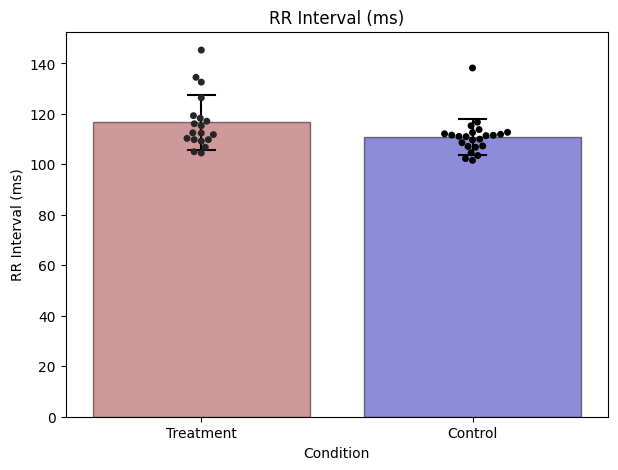

In [103]:
target_column = 'RR Interval (ms)'
create_barplots(df, group_column=group_column, target_column=target_column)


reading csv files...


  0%|          | 0/42 [00:00<?, ?it/s]

Column: RR Interval (ms)
No significant difference between conditions (p-value = 0.06144879474834282)
Column: Heart Rate (BPM)
No significant difference between conditions (p-value = 0.061459314919260724)
Column: PR Interval (ms)
No significant difference between conditions (p-value = 0.10642610517205131)
Column: P Duration (ms)
Statistical difference between conditions (p-value = 3.7864461997683543e-07)
Column: QRS Interval (ms)
No significant difference between conditions (p-value = 0.6922760376656696)
Column: QT Interval (ms)
No significant difference between conditions (p-value = 0.6859461851755858)
Column: QTc (ms)
Statistical difference between conditions (p-value = 4.670846917342462e-08)


(<Figure size 700x500 with 1 Axes>,
 <Axes: title={'center': 'RR Interval (ms)'}, xlabel='Condition', ylabel='RR Interval (ms)'>)

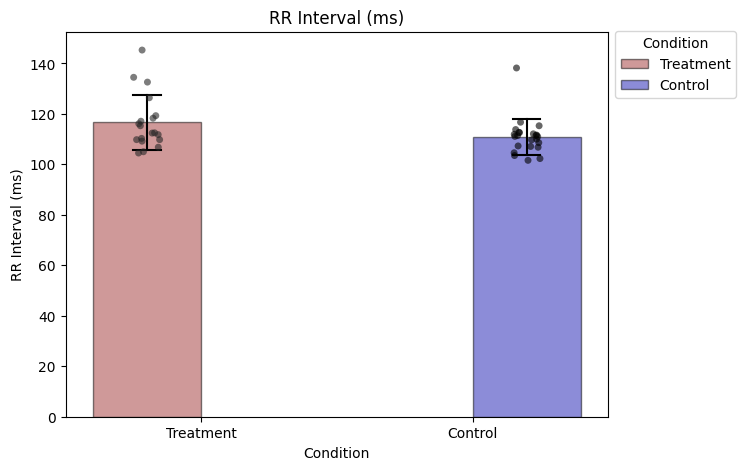

In [47]:
# Get a folder path
folder_path = './drive/MyDrive/ECG_files/'
file_paths = get_file_paths(folder_path)

# Read CSV files and create a DataFrame
df = read_csv_files(file_paths)

df = convert_datetime(df)

meta = read_meta_file(folder_path)
df = meta.merge(df, how='left')

# Run normality tests on each column
normality_results = run_normality_tests(df.iloc[:,3:])

# Perform statistical tests based on normality
group_column = 'Condition'

# trim two unnecessary cols
cols_drop = ['Exp_Id','TimeDate']
df_analysis = df.drop(cols_drop,axis=1)
p_values = run_statistical_tests(df_analysis, group_column)

for column, p_value in p_values.items():

  print(f"Column: {column}")
  if p_value < 0.05:
      print(f"Statistical difference between conditions (p-value = {p_value})")
  else:
      print(f"No significant difference between conditions (p-value = {p_value})")

# Create plots
target_column = 'RR Interval (ms)'
create_barplots(df, group_column=group_column, target_column=target_column)


In [9]:
p_values

{'RR Interval (ms)': 0.06144879474834282,
 'Heart Rate (BPM)': 0.061459314919260724,
 'PR Interval (ms)': 0.10642610517205131,
 'P Duration (ms)': 3.7864461997683543e-07,
 'QRS Interval (ms)': 0.6922760376656696,
 'QT Interval (ms)': 0.6859461851755858,
 'QTc (ms)': 4.670846917342462e-08}

In [86]:
first_date, last_date = df.TimeDate.min(), df.TimeDate.max()
first_date, last_date


('2021/10/26', '2022/05/03')